<a href="https://colab.research.google.com/github/silent-ai/chessboard/blob/main/chessboard_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab
! pip install fastai --upgrade

Requirement already up-to-date: fastai in /usr/local/lib/python3.6/dist-packages (2.1.7)


# Segmentation

In [ ]:
from fastai.vision.all import *

In [ ]:
path = untar_data(URLs.CAMVID_TINY)

In [ ]:
path.ls()

(#3) [Path('/root/.fastai/data/camvid_tiny/codes.txt'),Path('/root/.fastai/data/camvid_tiny/labels'),Path('/root/.fastai/data/camvid_tiny/images')]

In [ ]:
(path/'labels').ls()[0]

Path('/root/.fastai/data/camvid_tiny/labels/0016E5_05310_P.png')

In [ ]:
path_img = path/'images'
fnames = get_image_files(path_img)

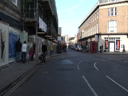

In [ ]:
example_img = fnames[0]
# PILImage.create(example_img).show()
Image.open(example_img)

In [ ]:
label_func = lambda x: path/'labels'/f'{x.stem}_P{x.suffix}'
example_mask = label_func(example_img)
example_mask

Path('/root/.fastai/data/camvid_tiny/labels/0016E5_08340_P.png')

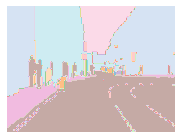

In [ ]:
PILMask.create(example_mask).show()

In [ ]:
codes = np.loadtxt(path/'codes.txt', dtype=str)

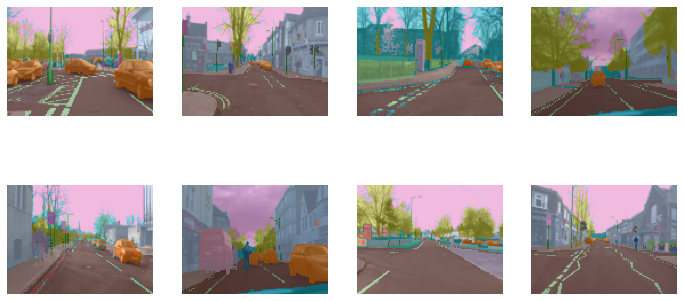

In [ ]:
dls = SegmentationDataLoaders.from_label_func(path, fnames, label_func, bs=8, codes=codes)
dls.show_batch()

In [ ]:
learn = unet_learner(dls, models.resnet34)

In [ ]:
learn.fine_tune(8)

epoch,train_loss,valid_loss,time
0,3.056418,2.502749,00:03


epoch,train_loss,valid_loss,time
0,1.913383,1.518152,00:01
1,1.650832,1.392003,00:01
2,1.500919,1.288441,00:01
3,1.369704,1.163931,00:01
4,1.239246,1.013662,00:01
5,1.127861,0.973780,00:01
6,1.031026,0.923260,00:01
7,0.950556,0.927784,00:01


In [ ]:
learn.validate()

(#1) [0.9277836084365845]

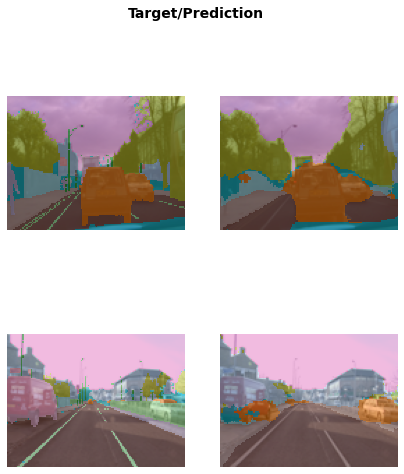

In [ ]:
learn.show_results(max_n=16, figsize=(7,8))

# Points

In [ ]:
path = untar_data(URLs.BIWI_HEAD_POSE)
path.ls()

(#50) [Path('/root/.fastai/data/biwi_head_pose/05.obj'),Path('/root/.fastai/data/biwi_head_pose/24'),Path('/root/.fastai/data/biwi_head_pose/11.obj'),Path('/root/.fastai/data/biwi_head_pose/02.obj'),Path('/root/.fastai/data/biwi_head_pose/09'),Path('/root/.fastai/data/biwi_head_pose/14.obj'),Path('/root/.fastai/data/biwi_head_pose/12'),Path('/root/.fastai/data/biwi_head_pose/15'),Path('/root/.fastai/data/biwi_head_pose/06.obj'),Path('/root/.fastai/data/biwi_head_pose/10')...]

In [ ]:
img_files = get_image_files(path)
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0])

Path('/root/.fastai/data/biwi_head_pose/24/frame_00280_pose.txt')

In [ ]:
im = PILImage.create(img_files[0])
im.shape

(480, 640)

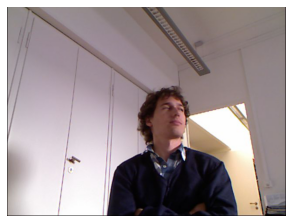

In [ ]:
im.show()

In [ ]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([[c1,c2], [0, 0]])

In [ ]:
import pandas as pd

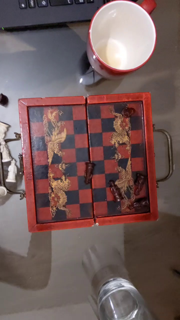

In [ ]:
path = Path('./frames')
imgs = get_image_files(path)
PILImage.create(imgs[0]).resize(size=(180, 320))

In [ ]:
def trim(x):
  points = [float(x) for x in x.values[0][3:-1].split(',')]
  return list(zip(points[::2], points[1::2]))

In [ ]:
vgg = pd.read_csv('export.csv', header=None)
labels = vgg[[1, 4]].set_index(1)
labels = labels.apply(trim, axis=1)
labels

1
["frame0.jpg"]            [(251.65, 320.0), (3.107, 605.825), (389.903, 831.068), (615.146, 483.107)]
["frame20.jpg"]          [(251.65, 389.903), (41.942, 708.35), (469.126, 894.757), (630.68, 521.942)]
["frame40.jpg"]        [(215.922, 411.65), (104.078, 790.68), (579.417, 871.456), (624.466, 455.146)]
["frame80.jpg"]        [(116.505, 540.583), (233.01, 977.087), (717.67, 817.087), (545.243, 419.417)]
["frame100.jpg"]     [(250.097, 500.194), (173.981, 852.816), (587.184, 924.272), (613.592, 560.777)]
["frame120.jpg"]       [(209.709, 517.282), (62.136, 773.592), (382.136, 925.825), (487.767, 644.66)]
["frame140.jpg"]      [(46.602, 776.699), (337.087, 1034.563), (546.796, 784.466), (288.932, 571.65)]
["frame200.jpg"]     [(69.903, 675.728), (186.408, 1088.932), (593.398, 944.466), (445.825, 590.291)]
["frame220.jpg"]    [(37.282, 796.893), (152.233, 1253.592), (598.058, 1070.291), (424.078, 669.515)]
["frame340.jpg"]    [(41.942, 782.913), (198.835, 1255.146), (646.214, 1056.311)

In [ ]:
def get_label(f):
  return tensor(labels.loc[f'["{f.name}"]'])

In [ ]:
example = 

SyntaxError: ignored

In [ ]:
get_label(Path('frame120.jpg'))

tensor([[209.7090, 517.2820],
        [ 62.1360, 773.5920],
        [382.1360, 925.8250],
        [487.7670, 644.6600]])

In [ ]:
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_label,
    item_tfms=Resize(320),
    batch_tfms=[Normalize.from_stats(*imagenet_stats)]
)

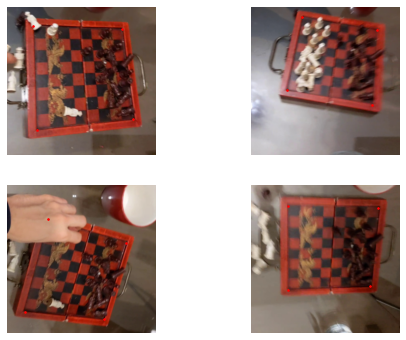

In [ ]:
dls = biwi.dataloaders(path, bs=4)
dls.show_batch(max_n=9, figsize=(8,6))

In [ ]:
learn = cnn_learner(dls, resnet18, y_range=(-1,1))

SuggestedLRs(lr_min=0.00831763744354248, lr_steep=1.737800812406931e-05)

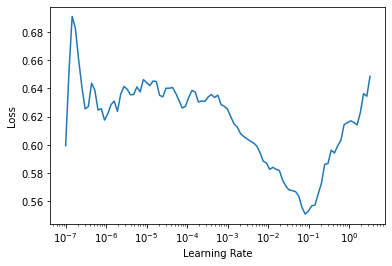

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(3, 10e-3)

epoch,train_loss,valid_loss,time
0,0.920554,0.588643,00:00


epoch,train_loss,valid_loss,time
0,0.727882,0.496823,00:01
1,0.706526,0.465438,00:01
2,0.678499,0.317453,00:00


In [ ]:
learn.show_results()

NameError: ignored